## Supplementary analyses

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scripts.utils import concat_dfs
import itertools

### Table of contents

* [Imports and preprocessing](#imports)
* [Some examples of association chains](#examples)
* [Jump size dynamics](#jump-size)
* [Jump distributions for some sample trials](#jump-dist)
* [Visualize trials in vector space](#vector-space)
* [Visualize number of dead-ends by diversity level](#dead-ends)

### Imports and preprocessing <a class="anchor" id="imports"></a>

In [2]:
PATH = 'animal_game/analyses/21_08_20'
LOG_PATH = 'animal_game/logs/21_08_20'
MODEL_PATH = 'animal_game/models/21_08_20'

In [3]:
data = pd.read_csv(f'{PATH}/processed.tsv.gz', 
                   sep='\t', compression='gzip')
aggs = pd.read_csv(f'{PATH}/aggregates.tsv', sep='\t')

In [14]:
data.rename({'noise_level_a0': 'diversity_level'}, axis=1, inplace=True)
aggs.rename({'noise_level_a0': 'diversity_level'}, axis=1, inplace=True)

In [15]:
all_data = data.copy()
all_aggs = aggs.copy()
aggs = aggs[aggs['diversity_level']<=14]
data = data[data['diversity_level']<=14]

In [16]:
data['diversity_dodge'] = data['diversity_level'] + \
                          np.random.uniform(-.2,.2,size=data.shape[0])
aggs['diversity_dodge'] = aggs['diversity_level'] + \
                          np.random.uniform(-.2,.2,size=aggs.shape[0])

In [69]:
data['best_agent'] = np.where(data['performance_a0']==data['performance_best'],
                              data['agent_0'],
                              data['agent_1'])

### Some examples of association chains <a class="anchor" id="examples"></a>

Below, some association chains for randomly sampled trials, at all diversity levels, with seed word "goat".

In [64]:
seed = 'goat'
for didx, dl in enumerate(range(0,15)):
    subdata = data[(data['diversity_level']==dl) &\
                   (data['init_seed']=='goat')]
    print(f'\033[1m\033[34mNoise level: {dl}\033[0m')
    sampled = subdata.sample(n=1, random_state=0)
    pairs = sampled.pair.tolist()
    a0s = sampled.agent_0.tolist()
    a1s = sampled.agent_1.tolist()
    for idx, (p, a0, a1) in enumerate(list(zip(pairs, a0s, a1s))):
        pair = p +'_2_0.01179.txt'
        agent0 = a0 +'_1_0.01179.txt'
        a0df = pd.read_csv(f'{LOG_PATH}/individual/{agent0}')
        a0df = a0df[a0df['init_seed']==seed].response.tolist()
        agent1 = a1 +'_1_0.01179.txt'
        a1df = pd.read_csv(f'{LOG_PATH}/individual/{agent1}')
        a1df = a1df[a1df['init_seed']==seed].response.tolist()
        pdf = pd.read_csv(f'{LOG_PATH}/pairs/{pair}')
        plist = pdf[pdf['init_seed']==seed].response.tolist()
        print('\033[1mAgent 0\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(a0df)+ '\n')
        print('\033[1mAgent 1\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(a1df)+ '\n')
        print('\033[1mPair\033[0m: ' + f'\033[1m\033[31m{seed}\033[0m, ' + ', '.join(plist) + '\n\n')

Noise level: 0
Agent 0: goat, cow, pig, chicken, duck, goose, pheasant, deer, elk, antelope, bison, black_bear, grizzly_bear, polar_bear, killer_whale, sperm_whale, blue_whale, fin_whale, whale, dolphin, shark, squid, cuttlefish, sawfish, sea_snake, coral_snake, diamondback_rattlesnake, cottonmouth, copperhead, rattlesnake, snake, lizard, toad, frog, salamander, turtle, tortoise, elephant, rhinoceros, giraffe, baboon, hyena, polecat, weasel, rabbit, dog, cat, poodle, dachshund, pekingese, hamster, guinea_pig, chimpanzee, bonobo, okapi, gazelle, leopard, tiger, lion, eagle, hawk, sparrow, parrot, parakeet, woodpecker, squirrel, rat, mouse, monkey, gorilla, crocodile, alligator, eel, catfish, prawn, shrimp, lobster, crab, jellyfish, starfish, harvestman, millipede, saurian, anteater, armadillo, tapir, caiman, iguana, gecko, chameleon, tarantula, scorpion, spider, ant, wasp, dragonfly, butterfly, swallowtail, red_admiral, aphid, beetle, cockroach, louse, platypus, koala, wombat, dingo, ka

## Jump size dynamics <a class="anchor" id="jump-size"></a>

The plots below show the jumps size dynamics for a few, randomly sampled trials, with "goat" as seed word.

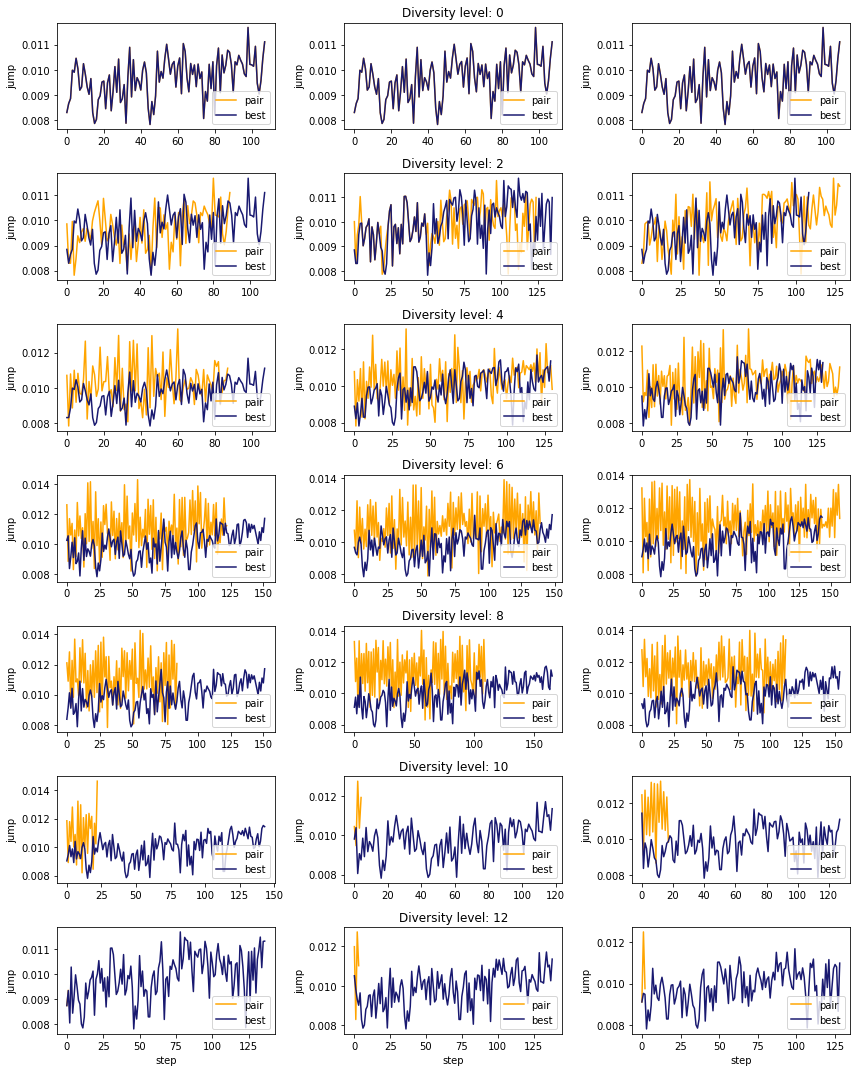

In [103]:
levels = list(range(0,13,2))
n_sampled = 3

fig, ax = plt.subplots(nrows=len(levels), 
                       ncols=n_sampled, 
                       figsize=(12,15))

for dlidx, dl in enumerate(levels):
    subdata = data[(data['diversity_level']==dl) &\
                   (data['init_seed']=='goat')]
    sampled = subdata[['pair', 
                       'amount_gain', 
                       'best_agent', 
                       'init_seed']].sample(n=n_sampled).sort_values('amount_gain')
    pairs = sampled.pair.tolist()
    best_agents = sampled.best_agent.tolist()
    for idx, (pair, best) in enumerate(list(zip(pairs, 
                                                best_agents))):
        pair_id = pair +'_2_0.01179.txt'
        agent = best +'_1_0.01179.txt'
        if best == subdata['agent_0'].iloc[0]:
            target_probs = 'prob0'
        else:
            target_probs = 'prob1'
            
        pdf = pd.read_csv(f'{LOG_PATH}/pairs/{pair_id}')
        pdf = pdf[pdf['init_seed']=='goat']
        idf = pd.read_csv(f'{LOG_PATH}/individual/{agent}')
        idf = idf[idf['init_seed']=='goat']
        
        sns.lineplot(data=pdf.reset_index(),
                     y=target_probs, 
                     x=range(pdf.shape[0]),
                     label='pair', 
                     ax=ax[(dlidx, idx)], 
                     color='orange')
        
        sns.lineplot(data=idf.reset_index(),
                     y='prob0', 
                     x=range(idf.shape[0]),
                     label='best', 
                     ax=ax[(dlidx, idx)], 
                     color='midnightblue')
        
        ax[(dlidx, idx)].set_ylabel('jump')
        ax[(dlidx, idx)].legend(loc='lower right')
        
        if idx == 1:
            ax[(dlidx, idx)].set_title(f'Diversity level: {dl}', 
                                       y=1.002)
        if dlidx == 6:
            ax[(dlidx, idx)].set_xlabel('step')
            
plt.tight_layout()
plt.show()

## Jump distributions for some sample trials <a class="anchor" id="jump-dist"></a>

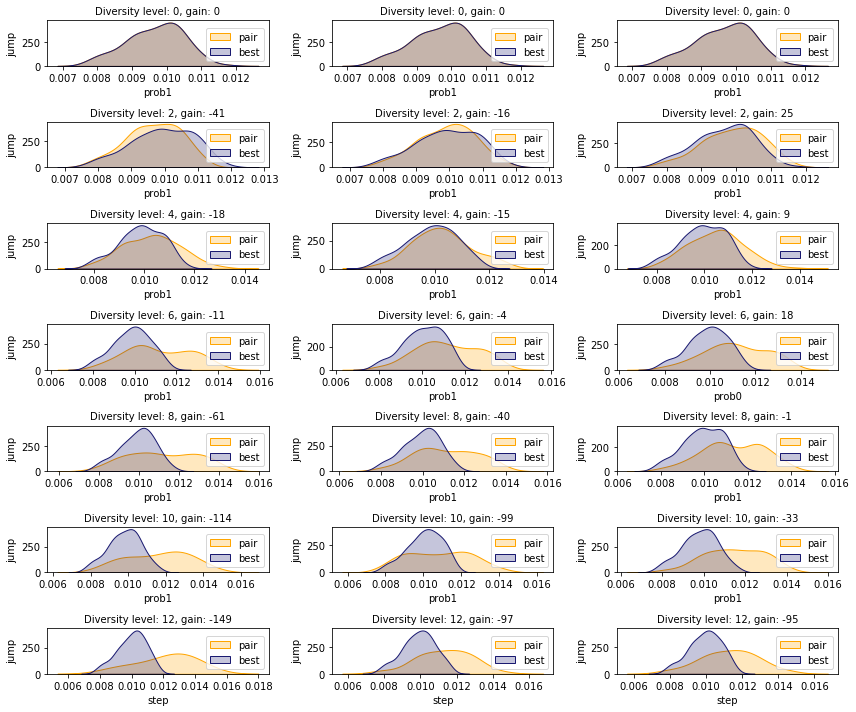

In [143]:
fig, ax = plt.subplots(nrows=len(levels), 
                       ncols=n_sampled, 
                       figsize=(12,10))

for dlidx, dl in enumerate(levels):
    subdata = data[(data['diversity_level']==dl) &\
                   (data['init_seed']=='goat')]
    sampled = subdata[['pair', 
                       'amount_gain', 
                       'best_agent', 
                       'init_seed']].sample(n=n_sampled).sort_values('amount_gain')
    pairs = sampled.pair.tolist()
    best_agents = sampled.best_agent.tolist()
    gains = sampled.amount_gain.tolist()
    for idx, (pair, best, gain) in enumerate(list(zip(pairs, 
                                                      best_agents,
                                                      gains))):
        pair_id = pair +'_2_0.01179.txt'
        agent = best +'_1_0.01179.txt'
        if best == subdata['agent_0'].iloc[0]:
            target_probs = 'prob0'
        else:
            target_probs = 'prob1'
            
        pdf = pd.read_csv(f'{LOG_PATH}/pairs/{pair_id}')
        pdf = pdf[pdf['init_seed']==seed]
        idf = pd.read_csv(f'{LOG_PATH}/individual/{agent}')
        idf = idf[idf['init_seed']==seed]
        
        sns.kdeplot(data=pdf.reset_index(),
                    x=target_probs,
                    label='pair', 
                    ax=ax[(dlidx, idx)], 
                    color='orange', 
                    fill=True)
        
        sns.kdeplot(data=idf.reset_index(),
                     x='prob0', 
                     label='best', 
                     ax=ax[(dlidx, idx)], 
                     color='midnightblue', 
                     fill=True)
        
        ax[(dlidx, idx)].set_ylabel('jump')
        ax[(dlidx, idx)].legend(loc='lower right')
        ax[(dlidx, idx)].set_title(f'Diversity level: {dl}, gain: {gain}',
                                   fontsize=10)
        if dlidx == 6:
            ax[(dlidx, idx)].set_xlabel('step')
            
plt.tight_layout()
plt.show()

## Visualize trials in vector space <a class="anchor" id="vector-space"></a>

Here we visualize some trials in a UMAP-reduced 2d version of agents' vector space. <br>
Some of these visualizations can be taken as examples of:
- Cases where doing the game in pairs avoids getting stuck in local minima = highly peripheral neighborhoods where no jump is possible within threshold;
- Cases where doing the game in pairs hinders exploring more isolated neighborhoods;
- How the dynamics of the game changes as diversity increases, with higher jumps and more exploration taking place (sometimes positively, sometimes negatively related to performance)

In [71]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1)

In [119]:
data_2 = data[data['noise_level_a0']==2.0]
best_pair_2 = data_2.sort_values('performance_pair').iloc[-1].pair

In [61]:
data_7 = data[data['noise_level_a0']==7.0]
best_pair_7 = data_7.sort_values('performance_pair').iloc[-1].pair

In [224]:
axs = [(0,0), (0,1), 
       (1,0), (1,1)]    
titles =  ['noise level 2, individual',
          'noise level 2, pair', 
          'noise level 7, individual',
          'noise level 7, pair']
idf1 = pd.read_csv(f'{LOG_PATH}/individual/{"_".join(best_pair_2.split("_")[:3])}_1_0.01179.txt')
idf1 = idf1[idf1['init_seed']=='goat']
pdf1 = pd.read_csv(f'{LOG_PATH}/pairs/{best_pair_2}_2_0.01179.txt')
pdf1 = pdf1[pdf1['init_seed']=='goat']
idf2 = pd.read_csv(f'{LOG_PATH}/individual/{"_".join(best_pair_7.split("_")[:3])}_1_0.01179.txt')
idf2 = idf2[idf2['init_seed']=='goat']
pdf2 = pd.read_csv(f'{LOG_PATH}/pairs/{best_pair_7}_2_0.01179.txt')
pdf2 = pdf2[pdf2['init_seed']=='goat']
ds = [idf1, pdf1, idf2, pdf2]

In [225]:
space1 = pd.read_csv(f'{MODEL_PATH}/noised_vectors/{"_".join(best_pair_2.split("_")[:3])}.tsv', 
                    sep='\t', index_col=0)
ad1 = dict(zip(space1.index, range(len(space1.index))))
scaled_space = StandardScaler().fit_transform(space1)
embedding1 = reducer.fit_transform(scaled_space)
space2 = pd.read_csv(f'{MODEL_PATH}/noised_vectors/{"_".join(best_pair_7.split("_")[:3])}.tsv', 
                    sep='\t', index_col=0)
ad2 = dict(zip(space2.index, range(len(space2.index))))
scaled_space = StandardScaler().fit_transform(space2)
embedding2 = reducer.fit_transform(scaled_space)
adicts = [ad1, ad1, ad2, ad2]
spaces = [embedding1, embedding1, embedding2, embedding2]

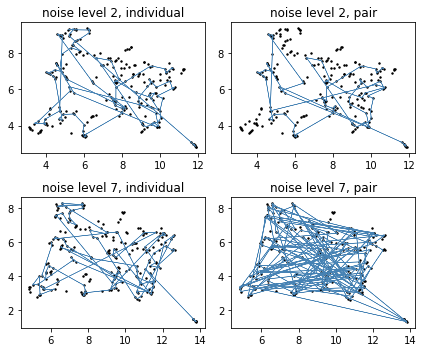

In [226]:
f, ax = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

for idx in range(4):
    animal_dict = adicts[idx]
    pdf = ds[idx]
    embedding = spaces[idx]
    named = pdf.seed.tolist() + [pdf.response.tolist()[-1]]
    named_idx = [animal_dict[i] for i in named]
    xs = [embedding[n,0] for n in named_idx]
    ys = [embedding[n,1] for n in named_idx]
    for ix in range(len(xs)-1):
        ax[axs[idx]].arrow(x=xs[ix], 
                    y=ys[ix], 
                    dx=xs[ix+1]-xs[ix],
                    dy=ys[ix+1]-ys[ix],
                    shape='full', 
                    lw=.5,
                    length_includes_head=True, 
                    head_width=.05, 
                    color='steelblue')
    ax[axs[idx]].scatter(embedding[:,0], 
                         embedding[:,1], s=2, color='k')
    ax[axs[idx]].set_title(titles[idx])
    
plt.tight_layout()
plt.show()

## Visualize number of dead-ends by diversity level <a class="anchor" id="dead-ends"></a>
The plot below is a histogram of how often each word in space is the last named in a trial, across diversity levels.
This gives an idea of how label swapping - used to generate diversity levels - increases the number of possible dead-ends in a pair. Low-diversity pairs will have roughly the same dead-end animals, but as diversity increases, both the semantics of the spece and dead ends will tend to differ within the pair - which increases chances of responses from one agent in a dense neighborhood unexpectedly leading the other agent to an isolated neighborhood and a dead end.

In [153]:
animals = pd.read_csv(f'animal_game/models/animal_list.csv').rename({'Animals': 
                                                                     'last_response_pair'}, 
                                                                      axis=1)
animals = concat_dfs([animals]*20) 
animals['diversity_level'] = list(itertools.chain(*[[dl] * 240 
                                                    for dl in range(0,20)]))

In [157]:
nr_last = all_data.groupby(['diversity_level', 
                            'last_response_pair'])['pair'].count().reset_index()
nr_last.rename({'pair': 'frequency'}, axis=1, inplace=True)
nr_last = nr_last.merge(animals, 'outer')
nr_last['frequency'] = nr_last['frequency'].fillna(0)
nr_last['log_frequency'] = np.where(nr_last['frequency']!=0, 
                                    np.log10(nr_last['frequency']), 0)

/home/roberta/venvs/dl_test/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


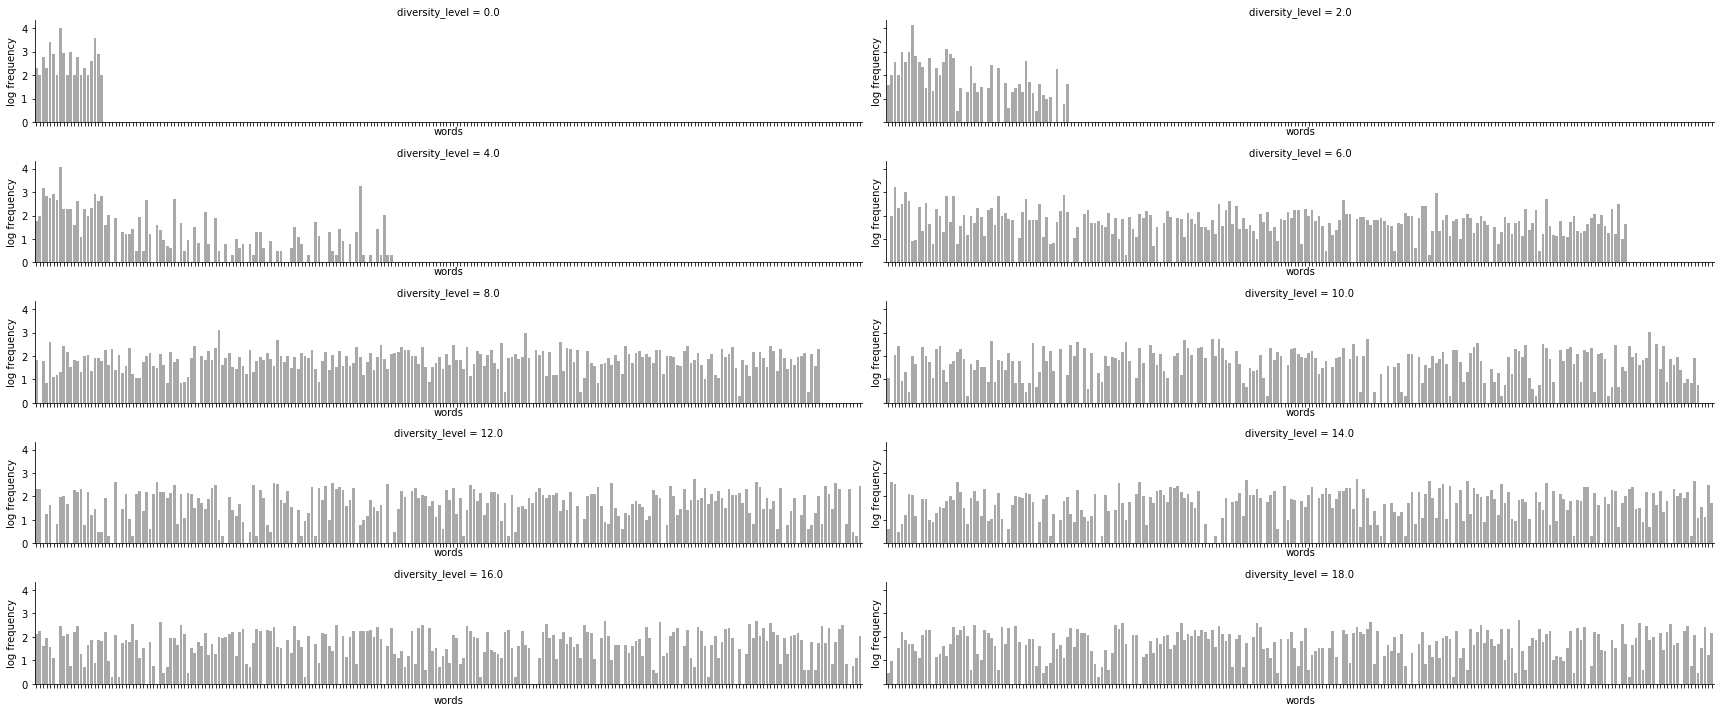

In [172]:
f = sns.catplot(data=nr_last[nr_last['diversity_level'].isin(list(range(0,20,2)))], 
                col='diversity_level', 
                col_wrap=2, 
                x='last_response_pair', 
                y='log_frequency',
                height=2, 
                aspect=6, 
                facet_kws={'sharey': False},
                kind='bar',
                color='darkgrey')
for a in f.axes:
    a.set_xlabel('words')
    a.set_ylabel('log frequency')
f.set(xticklabels=[])
plt.tight_layout()
plt.show()